In [108]:
import os

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

%matplotlib inline

In [114]:
image_path = '../../data/COCO/val2017'
ann_path = '../../data/COCO/annotations/instances_val2017.json'
dataset = CocoDetection(root=image_path, annFile=ann_path, transform=transforms.ToTensor())

loader = DataLoader(dataset)
img, tar = iter(loader).next()

print(img.shape)
print(len(tar))

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
torch.Size([1, 3, 426, 640])
20


In [115]:
class myCocoDetection(CocoDetection):
    def _load_image(self, idx: int):
        path = self.coco.loadImgs(idx)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")
    
    def _load_target(self, idx):
        return self.coco.loadAnns(self.coco.getAnnIds(idx))
    
    def __getitem__(self, index: int):
        idx = self.ids[index]
        image = self._load_image(idx)
        target = self._load_target(idx)
        
        bboxes, labels = [], []
        for obj in target:
            bboxes.append(obj['bbox'])
            labels.append(obj['category_id'])
            
        labels = torch.tensor(labels)
        if self.transform:
            image = self.transform(image)
            bboxes = self.transform(np.array(bboxes))
            
        return image, bboxes, labels
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [116]:
dataset = myCocoDetection(root=image_path, annFile=ann_path, transform=transforms.ToTensor())
dataset

dataset_loader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

images, bboxes, labels = iter(dataset_loader).next()

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [117]:
print('Shape of Image :', images[0].shape)
print('Shape of bboxes :', bboxes[0].shape)
print('Shape of labels :', len(labels))

Shape of Image : torch.Size([3, 426, 640])
Shape of bboxes : torch.Size([1, 20, 4])
Shape of labels : 4


# Visualization

In [106]:
def coco_show(dataloader, figsize):
    CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    
    images, bboxes, labels = iter(dataloader).next()
    
    fig, axes = plt.subplots(*figsize, figsize=(15,10))
    axes = axes.ravel()
    for i in range(len(images)):
        img = images[i].permute(1,2,0)
        
        for box, label in zip(bboxes[i][0], labels[i]):
            rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none') 
            axes[i].add_patch(rect)
            axes[i].text(box[0], box[1], CLASSES[label], fontsize=15)
            
        axes[i].imshow(img)
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show() 

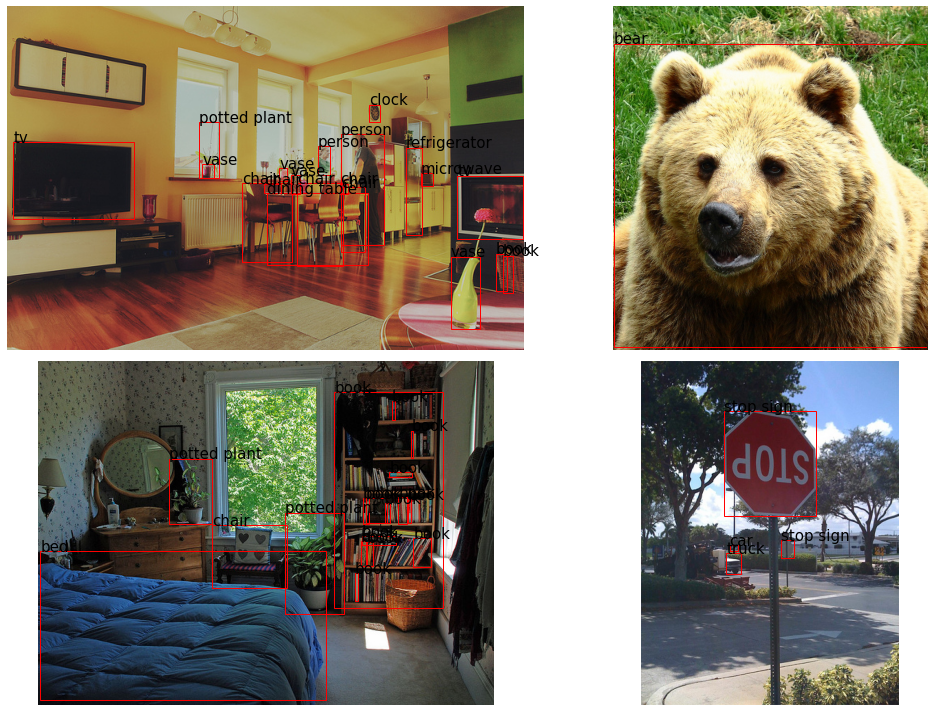

In [107]:
coco_show(dataset_loader, figsize=(2,2))